# Retweet/Quote Analysis

This notebook deals with the questions around how the retweet/quote is used among the politicians.

In [160]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [161]:
# Variable to select the date range from which on the tweets should be considered
# When Original Tweet was created
date_parameter_tweet_selection = pd.to_datetime('2021-08-30') # Voting: '2021-09-26', Official Start: '2021-10-26'

In [162]:
user_friendships_evaluation = pd.read_csv('../data/processed/user_friendships_evaluation.csv', sep=";", na_values="", dtype={'source_id': str, 'target_id': str})
user_list = pd.read_csv('../data/processed/user_list.csv', sep=";", na_values="", dtype={'twitter_id': str})
mdb_list = pd.read_csv('../data/processed/mdb_list.csv', sep=";", na_values="")

retweet_list = pd.read_csv('../data/processed/retweet_list.csv', sep=";", na_values="", lineterminator='\n')
quote_list = pd.read_csv('../data/processed/quote_list.csv', sep=";", na_values="", lineterminator='\n')

In [163]:
user_list['twitter_id'] = pd.to_numeric(user_list['twitter_id'])

mdb_list['fraktion_short'] = mdb_list['fraktion']
mdb_list['fraktion_short'][mdb_list['fraktion'] == 'Alternative für Deutschland'] = 'AfD'
mdb_list['fraktion_short'][mdb_list['fraktion'] == 'Fraktion BÜNDNIS 90/DIE GRÜNEN'] = 'Grünen'
mdb_list['fraktion_short'][mdb_list['fraktion'] == 'Fraktion DIE LINKE.'] = 'Linke'
mdb_list['fraktion_short'][mdb_list['fraktion'] == 'Fraktion der Christlich Demokratischen Union/Christlich - Sozialen Union'] = 'CDU'
mdb_list['fraktion_short'][mdb_list['fraktion'] == 'Fraktion der Freien Demokratischen Partei'] = 'FDP'
mdb_list['fraktion_short'][mdb_list['fraktion'] == 'Fraktion der Sozialdemokratischen Partei Deutschlands'] = 'SPD'

### RETWEETS ###

# Merge follow and tie information into table
retweet_list_enriched = pd.merge(retweet_list, user_friendships_evaluation, how='left', left_on=['retweeter_twitter_handle', 'author_twitter_handle'], right_on=['source_screen_name', 'target_screen_name'])
retweet_list_enriched = pd.merge(retweet_list_enriched, user_friendships_evaluation, how='left', left_on=['retweeter_twitter_handle', 'author_twitter_handle'], right_on=['target_screen_name', 'source_screen_name'])

# Filter retweets based on creation of the orignal tweet
retweet_list_enriched['tweet_created_at'] = pd.to_datetime(retweet_list_enriched['tweet_created_at']).dt.date
retweet_list_enriched = retweet_list_enriched[retweet_list_enriched['tweet_created_at'] > date_parameter_tweet_selection]

# Merge mergeable columns 
retweet_list_enriched['tie_type_x'].update(retweet_list_enriched.pop('tie_type_y'))
retweet_list_enriched['source_follows_target_x'].update(retweet_list_enriched.pop('target_follows_source_y'))
retweet_list_enriched['target_follows_source_x'].update(retweet_list_enriched.pop('source_follows_target_y'))

# Fill info for same person or not available
retweet_list_enriched['tie_type_x'][retweet_list_enriched['retweeter_twitter_handle'] == retweet_list_enriched['author_twitter_handle']] = 'same person' 
retweet_list_enriched['tie_type_x'][retweet_list_enriched['tie_type_x'].isna()] = 'not available'

# Drop empty columns
retweet_list_enriched.drop(['source_screen_name_x', 'target_screen_name_x', 'source_id_x', 'target_id_x', 'source_screen_name_y', 'source_id_y', 'target_screen_name_y', 'target_id_y', 'tweet_referenced_tweet_type_x'], axis=1, inplace=True)

# Add the account information from user_list to the retweets
retweet_list_enriched = pd.merge(retweet_list_enriched, user_list, left_on='retweeter_twitter_handle', right_on='twitter_handle')
retweet_list_enriched = pd.merge(retweet_list_enriched, user_list, left_on='author_twitter_handle', right_on='twitter_handle')
retweet_list_enriched.columns = retweet_list_enriched.columns.str.replace('_x', '_retweeter')
retweet_list_enriched.columns = retweet_list_enriched.columns.str.replace('_y', '_author')

# merge mdb_list
retweet_list_enriched = pd.merge(retweet_list_enriched, mdb_list, left_on='bundestag_id_retweeter', right_on='bundestag_id')
retweet_list_enriched = pd.merge(retweet_list_enriched, mdb_list, left_on='bundestag_id_author', right_on='bundestag_id')
retweet_list_enriched.columns = retweet_list_enriched.columns.str.replace('_x', '_retweeter')
retweet_list_enriched.columns = retweet_list_enriched.columns.str.replace('_y', '_author')

retweet_list_enriched.rename(columns={"source_follows_target_retweeter": "retweeter_follows_author", "target_follows_source_retweeter": "author_follows_retweeter" }, inplace=True)


### QUOTES ###

# Merge follow and tie information into table
quote_list_enriched = pd.merge(quote_list, user_friendships_evaluation, how='left', left_on=['quoter_twitter_handle', 'author_twitter_handle'], right_on=['source_screen_name', 'target_screen_name'])
quote_list_enriched = pd.merge(quote_list_enriched, user_friendships_evaluation, how='left', left_on=['quoter_twitter_handle', 'author_twitter_handle'], right_on=['target_screen_name', 'source_screen_name'])

# Filter retweets based on creation of the orignal tweet
quote_list_enriched['tweet_created_at'] = pd.to_datetime(quote_list_enriched['tweet_created_at']).dt.date
quote_list_enriched = quote_list_enriched[quote_list_enriched['tweet_created_at'] > date_parameter_tweet_selection]

# Merge mergeable columns 
quote_list_enriched['tie_type_x'].update(quote_list_enriched.pop('tie_type_y'))
quote_list_enriched['source_follows_target_x'].update(quote_list_enriched.pop('target_follows_source_y'))
quote_list_enriched['target_follows_source_x'].update(quote_list_enriched.pop('source_follows_target_y'))

# Fill info for same person or not available
quote_list_enriched['tie_type_x'][quote_list_enriched['quoter_twitter_handle'] == quote_list_enriched['author_twitter_handle']] = 'same person' 
quote_list_enriched['tie_type_x'][quote_list_enriched['tie_type_x'].isna()] = 'not available'

# Drop empty columns
quote_list_enriched.drop(['source_screen_name_x', 'target_screen_name_x', 'source_id_x', 'target_id_x', 'source_screen_name_y', 'source_id_y', 'target_screen_name_y', 'target_id_y', 'tweet_referenced_tweet_type_x'], axis=1, inplace=True)

# Add the account information from user_list to the quotes
quote_list_enriched = pd.merge(quote_list_enriched, user_list, left_on='quoter_twitter_handle', right_on='twitter_handle')
quote_list_enriched = pd.merge(quote_list_enriched, user_list, left_on='author_twitter_handle', right_on='twitter_handle')
quote_list_enriched.columns = quote_list_enriched.columns.str.replace('_x', '_quoter')
quote_list_enriched.columns = quote_list_enriched.columns.str.replace('_y', '_author')

# merge mdb_list
quote_list_enriched = pd.merge(quote_list_enriched, mdb_list, left_on='bundestag_id_quoter', right_on='bundestag_id')
quote_list_enriched = pd.merge(quote_list_enriched, mdb_list, left_on='bundestag_id_author', right_on='bundestag_id')
quote_list_enriched.columns = quote_list_enriched.columns.str.replace('_x', '_quoter')
quote_list_enriched.columns = quote_list_enriched.columns.str.replace('_y', '_author')

quote_list_enriched.rename(columns={"source_follows_target_quoter": "quoter_follows_author", "target_follows_source_quoter": "author_follows_quoter" }, inplace=True)

display(quote_list_enriched)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


,quoter_twitter_handle,quote_tweet_id,quote_text,quoter_twitter_id,quote_created_at,author_twitter_handle,tweet_id,tweet_text,author_twitter_id,tweet_created_at,...,mdbwp_bis_author,wkr_nummer_author,wkr_name_author,wkr_land_author,liste_author,mandatsart_author,fraktion_author,ministerium_author,fkt_lang_author,fraktion_short_author
0,n_roettgen,1519669020970082304,Das ist Putin-Propaganda in Reinform. Applaus ...,1040160799208161280,2022-04-28 13:25:03+00:00,SevimDagdelen,1519652748052119552,Der #Bundestag hat heute nichts weniger als de...,139407967,2022-04-28,...,NaN,NaN,NaN,NaN,NW,Landesliste,Fraktion DIE LINKE.,NaN,NaN,Linke
1,LFLindemann,1519676335752454173,Irre. https://t.co/k6tKs8iHFC,96146500,2022-04-28 13:54:07+00:00,SevimDagdelen,1519652748052119552,Der #Bundestag hat heute nichts weniger als de...,139407967,2022-04-28,...,NaN,NaN,NaN,NaN,NW,Landesliste,Fraktion DIE LINKE.,NaN,NaN,Linke
2,n_roettgen,1498619831301644295,Bei allem Respekt gegenüber der Kollegin - es ...,1040160799208161280,2022-03-01 11:23:05+00:00,SWagenknecht,1498574635088195584,Hauptforderungen von Putin für Kriegsende sind...,47375691,2022-03-01,...,NaN,NaN,NaN,NaN,NW,Landesliste,Fraktion DIE LINKE.,NaN,NaN,Linke
3,KaiGehring,1501591918022737926,Die Pressesprecherin des Kreml verdreht einmal...,110368456,2022-03-09 16:13:06+00:00,SWagenknecht,1501582349758341120,#Scholz &amp; #Baerbock sollten die russische ...,47375691,2022-03-09,...,NaN,NaN,NaN,NaN,NW,Landesliste,Fraktion DIE LINKE.,NaN,NaN,Linke
4,MartinaRenner,1466379569695440901,Der Anthroposoph #Schily verbreitet in dem Art...,68920005,2021-12-02 12:11:48+00:00,SWagenknecht,1466362348973838336,Otto #Schily: allgemeine #Impfpflicht ist verf...,47375691,2021-12-02,...,NaN,NaN,NaN,NaN,NW,Landesliste,Fraktion DIE LINKE.,NaN,NaN,Linke
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
902,KayGottschalk1,1470983297543163909,Auf gute Zusammenarbeit! https://t.co/x2CPzazR...,1286011081,2021-12-15 05:05:22+00:00,KayGottschalk1,1470983029959110656,"Danke, für das Vertrauen! ⁦@AfDimBundestag⁩ ⁦@...",1286011081,2021-12-15,...,NaN,NaN,NaN,NaN,NW,Landesliste,Alternative für Deutschland,NaN,NaN,AfD
903,verenahubertz,1493570790549344257,@_FranzMichel @DFoest @KuehniKev @CanselK @Oli...,3591923477,2022-02-15 13:00:00+00:00,verenahubertz,1493559000172048384,Vereinbart ist vereinbart. Wir wollen Mieter b...,3591923477,2022-02-15,...,NaN,203.0,Trier,RP,NaN,Direktwahl,Fraktion der Sozialdemokratischen Partei Deuts...,NaN,NaN,SPD
904,ulschzi,1506626457916915712,Ihr wollt wissen wieso uns niemand in der Welt...,866924100,2022-03-23 13:38:33+00:00,Beatrix_vStorch,1506622622947328000,Das ist die protokollarisch zweithöchste Reprä...,805308596,2022-03-23,...,NaN,NaN,NaN,NaN,BE,Landesliste,Alternative für Deutschland,NaN,NaN,AfD
905,UlrichLange,1513468520016789505,Die aktuell extrem hohen #Energiepreise treibe...,68172699,2022-04-11 10:46:28+00:00,UlrichLange,1492113507667562496,"Absurde Forderung von @Umweltbundesamt, künfti...",68172699,2022-02-11,...,NaN,254.0,Donau-Ries,BY,NaN,Direktwahl,Fraktion der Christlich Demokratischen Union/C...,NaN,NaN,CDU


### 1. What is the social tie between author and retweeter/quoter?

In [164]:
#### RETWEETS ####

# Create data frame with the results
retweet_social_ties = pd.DataFrame(columns=['tie_type', 'retweet_count'])
retweet_social_ties.loc[len(retweet_social_ties.index)] = ['weak', retweet_list_enriched[retweet_list_enriched['tie_type_retweeter'] == 'weak'].shape[0]]
retweet_social_ties.loc[len(retweet_social_ties.index)] = ['strong', retweet_list_enriched[retweet_list_enriched['tie_type_retweeter'] == 'strong'].shape[0]]
retweet_social_ties.loc[len(retweet_social_ties.index)] = ['no tie', retweet_list_enriched[retweet_list_enriched['tie_type_retweeter'] == 'no tie'].shape[0]]
retweet_social_ties.loc[len(retweet_social_ties.index)] = ['same person', retweet_list_enriched[retweet_list_enriched['tie_type_retweeter'] == 'same person'].shape[0]]
retweet_social_ties.loc[len(retweet_social_ties.index)] = ['not available', retweet_list_enriched[retweet_list_enriched['tie_type_retweeter'] == 'not available'].shape[0]]

# Add a calculated percentage column
retweet_social_ties['retweet_count_percentage'] = round(retweet_social_ties.retweet_count / retweet_social_ties.retweet_count.sum() * 100, 1)

display(retweet_social_ties)

,tie_type,retweet_count,retweet_count_percentage
0,weak,664,15.4
1,strong,3433,79.4
2,no tie,101,2.3
3,same person,127,2.9
4,not available,0,0.0


In [165]:
#### QUOTES ####

# Create data frame with the results
quote_social_ties = pd.DataFrame(columns=['tie_type', 'quote_count'])
quote_social_ties.loc[len(quote_social_ties.index)] = ['weak', quote_list_enriched[quote_list_enriched['tie_type_quoter'] == 'weak'].shape[0]]
quote_social_ties.loc[len(quote_social_ties.index)] = ['strong', quote_list_enriched[quote_list_enriched['tie_type_quoter'] == 'strong'].shape[0]]
quote_social_ties.loc[len(quote_social_ties.index)] = ['no tie', quote_list_enriched[quote_list_enriched['tie_type_quoter'] == 'no tie'].shape[0]]
quote_social_ties.loc[len(quote_social_ties.index)] = ['same person', quote_list_enriched[quote_list_enriched['tie_type_quoter'] == 'same person'].shape[0]]
quote_social_ties.loc[len(quote_social_ties.index)] = ['not available', quote_list_enriched[quote_list_enriched['tie_type_quoter'] == 'not available'].shape[0]]

quote_social_ties['quote_count_percentage'] = round(quote_social_ties.quote_count / quote_social_ties.quote_count.sum() * 100, 1)
display(quote_social_ties)

,tie_type,quote_count,quote_count_percentage
0,weak,165,18.2
1,strong,462,50.9
2,no tie,93,10.3
3,same person,187,20.6
4,not available,0,0.0


### 2. How do the fractions retweet from each other?

tweet_id                                            \
fraktion_short_author         AfD    CDU    FDP Fraktionslos  Grünen  Linke   
fraktion_short_retweeter                                                      
AfD                         231.0    1.0    NaN          NaN     NaN    3.0   
CDU                           NaN  695.0   31.0          1.0     9.0    NaN   
FDP                           NaN    3.0  754.0          NaN    17.0    1.0   
Fraktionslos                  1.0    NaN    NaN          NaN     1.0    NaN   
Grünen                        NaN    2.0   15.0          2.0  1353.0    2.0   
Linke                         NaN    NaN    NaN          NaN     6.0  250.0   
SPD                           NaN    4.0   20.0          NaN    41.0    2.0   

                                 
fraktion_short_author       SPD  
fraktion_short_retweeter         
AfD                         1.0  
CDU                         7.0  
FDP                        20.0  
Fraktionslos                NaN  
Grünen                     25.0  
Linke                       3.0  
SPD                       697.0

,tie_type_retweeter,AfD,CDU,FDP,Fraktionslos,Grünen,Linke,SPD
0,no tie,3.0,26.0,19.0,2.0,16.0,7.0,28.0
1,strong,194.0,592.0,715.0,1.0,1223.0,199.0,509.0
2,weak,35.0,87.0,86.0,NaN,188.0,52.0,216.0


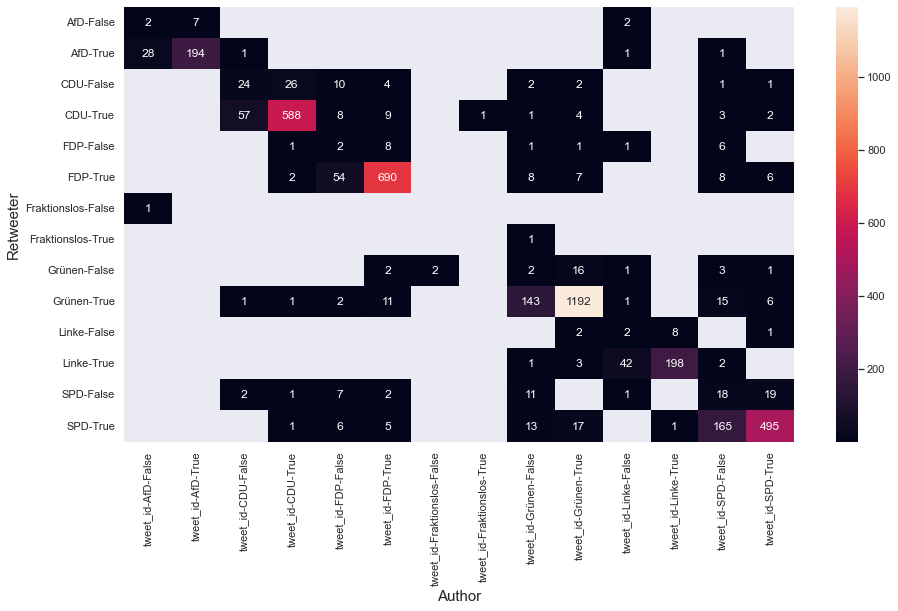

In [166]:
import warnings
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# filter out self-loops
retweet_list_enriched = retweet_list_enriched[(retweet_list_enriched['retweeter_twitter_handle'] != retweet_list_enriched['author_twitter_handle'])]

retweet_pivot = pd.pivot_table(retweet_list_enriched, index=['fraktion_short_retweeter'], columns=['fraktion_short_author'], values=['tweet_id'], aggfunc='count')
display(retweet_pivot)

retweet_pivot = pd.pivot_table(retweet_list_enriched, index=['fraktion_short_retweeter', 'retweeter_follows_author'], columns=['fraktion_short_author', 'author_follows_retweeter'], values=['tweet_id'], aggfunc='count')

sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(retweet_pivot, annot=True, fmt='.4g')
plt.xlabel('Author', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('Retweeter', fontsize = 15) # x-axis label with fontsize 15

same_fraction_pivot = pd.pivot_table(retweet_list_enriched, index=['tie_type_retweeter'], columns=['fraktion_short_author'], values=['fraktion_short_retweeter'], aggfunc='count')
same_fraction_pivot = same_fraction_pivot.droplevel(0, axis=1).rename_axis(None, axis=1).reset_index()
display(same_fraction_pivot)

tweet_id                               
fraktion_short_author      AfD   CDU   FDP Grünen Linke   SPD
fraktion_short_quoter                                        
AfD                        9.0   4.0   7.0    7.0   NaN   5.0
CDU                        1.0  66.0  25.0   25.0   2.0  32.0
FDP                        1.0   9.0  93.0   11.0   1.0  12.0
Grünen                     NaN  16.0   8.0  226.0   2.0  17.0
Linke                      NaN   6.0   4.0    3.0  21.0   8.0
SPD                        NaN   8.0   5.0    9.0   1.0  76.0

,tie_type_quoter,AfD,CDU,FDP,Grünen,Linke,SPD
0,no tie,1,22,19,28,3,20
1,strong,7,68,93,213,18,63
2,weak,3,19,30,40,6,67


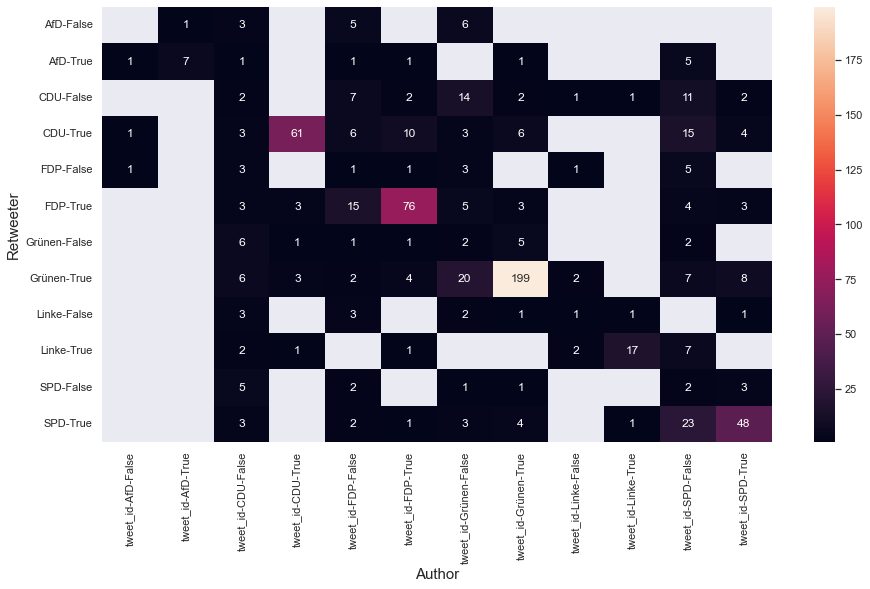

In [167]:
# filter out self-loops
quote_list_enriched = quote_list_enriched[(quote_list_enriched['quoter_twitter_handle'] != quote_list_enriched['author_twitter_handle'])]

quote_pivot = pd.pivot_table(quote_list_enriched, index=['fraktion_short_quoter'], columns=['fraktion_short_author'], values=['tweet_id'], aggfunc='count')
display(quote_pivot)

quote_pivot = pd.pivot_table(quote_list_enriched, index=['fraktion_short_quoter', 'quoter_follows_author'], columns=['fraktion_short_author', 'author_follows_quoter'], values=['tweet_id'], aggfunc='count')

sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(quote_pivot, annot=True, fmt='.4g')
plt.xlabel('Author', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('Retweeter', fontsize = 15) # x-axis label with fontsize 15

same_fraction_pivot = pd.pivot_table(quote_list_enriched, index=['tie_type_quoter'], columns=['fraktion_short_author'], values=['fraktion_short_quoter'], aggfunc='count')
same_fraction_pivot = same_fraction_pivot.droplevel(0, axis=1).rename_axis(None, axis=1).reset_index()
display(same_fraction_pivot)

### 3. Is there a correlation between In-Degree (Number of Retweets in this sample) and Followers-Count?

In [191]:
# Weighted In-Degree
groupby1 = retweet_list_enriched.groupby(by='author_twitter_handle').count()
display(groupby1.sort_values(by='retweet_tweet_id', ascending=False))

in_degree_followers = retweet_list_enriched[['author_twitter_handle', 'followers_count_author', 'fraktion_author']]
in_degree_followers.drop_duplicates(inplace=True)
in_degree_followers = pd.merge(in_degree_followers, groupby1, on="author_twitter_handle")
# in_degree_followers = in_degree_followers.droplevel(0, axis=1).rename_axis(None, axis=1).reset_index()

# sns.regplot(data=in_degree_followers, x="followers_count_author", y="retweeter_twitter_handle")


display(in_degree_followers)

# Weighted Out-Degree
groupby2 = retweet_list_enriched.groupby(by='retweeter_twitter_handle').count()
display(groupby2.sort_values(by='retweet_tweet_id', ascending=False))

,retweeter_twitter_handle,retweet_tweet_id,retweet_text,retweeter_twitter_id,retweet_created_at,tweet_id,tweet_text,author_twitter_id,tweet_created_at,retweeter_follows_author,...,mdbwp_bis_author,wkr_nummer_author,wkr_name_author,wkr_land_author,liste_author,mandatsart_author,fraktion_author,ministerium_author,fkt_lang_author,fraktion_short_author
author_twitter_handle,,,,,,,,,,,,,,,,,,,,,
c_lindner,142,142,142,142,142,142,142,142,142,142,...,0,0,0,0,142,142,142,142,142,142
_friedrichmerz,132,132,132,132,132,132,132,132,132,132,...,0,132,132,132,0,132,132,0,0,132
Bundeskanzler,123,123,123,123,123,123,123,123,123,123,...,0,123,123,123,0,123,123,123,123,123
BriHasselmann,100,100,100,100,100,100,100,100,100,100,...,0,0,0,0,100,100,100,0,0,100
MarcoBuschmann,100,100,100,100,100,100,100,100,100,100,...,0,0,0,0,100,100,100,100,100,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RogerBeckamp,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,1,1,1,0,0,1
AntjeTillmann,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,1,1,1,0,0,1
PeterAumer,1,1,1,1,1,1,1,1,1,1,...,0,1,1,1,0,1,1,0,0,1


,author_twitter_handle,followers_count_author_x,fraktion_author_x,fraktion_author_x,retweeter_twitter_handle,retweet_tweet_id,retweet_text,retweeter_twitter_id,retweet_created_at,tweet_id,...,mdbwp_bis_author,wkr_nummer_author,wkr_name_author,wkr_land_author,liste_author,mandatsart_author,fraktion_author_y,ministerium_author,fkt_lang_author,fraktion_short_author
0,Ricarda_Lang,103578.0,Fraktion BÜNDNIS 90/DIE GRÜNEN,Fraktion BÜNDNIS 90/DIE GRÜNEN,78,78,78,78,78,78,...,0,0,0,0,78,78,78,0,0,78
1,Oliver_Krischer,22321.0,Fraktion BÜNDNIS 90/DIE GRÜNEN,Fraktion BÜNDNIS 90/DIE GRÜNEN,35,35,35,35,35,35,...,0,35,35,35,0,35,35,35,35,35
2,ABaerbock,418545.0,Fraktion BÜNDNIS 90/DIE GRÜNEN,Fraktion BÜNDNIS 90/DIE GRÜNEN,79,79,79,79,79,79,...,0,0,0,0,79,79,79,79,79,79
3,ABaerbockArchiv,420662.0,Fraktion BÜNDNIS 90/DIE GRÜNEN,Fraktion BÜNDNIS 90/DIE GRÜNEN,44,44,44,44,44,44,...,0,0,0,0,44,44,44,44,44,44
4,filizgreen,6241.0,Fraktion BÜNDNIS 90/DIE GRÜNEN,Fraktion BÜNDNIS 90/DIE GRÜNEN,29,29,29,29,29,29,...,0,0,0,0,29,29,29,0,0,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380,DrJoeWeingarten,1492.0,Fraktion der Sozialdemokratischen Partei Deuts...,Fraktion der Sozialdemokratischen Partei Deuts...,1,1,1,1,1,1,...,0,1,1,1,0,1,1,0,0,1
381,SiemtjeMdB,9620.0,Fraktion der Sozialdemokratischen Partei Deuts...,Fraktion der Sozialdemokratischen Partei Deuts...,1,1,1,1,1,1,...,0,1,1,1,0,1,1,1,1,1
382,NinaScheer_SPD,4529.0,Fraktion der Sozialdemokratischen Partei Deuts...,Fraktion der Sozialdemokratischen Partei Deuts...,1,1,1,1,1,1,...,0,1,1,1,0,1,1,0,0,1
383,ChrWirthMdB,2775.0,Alternative für Deutschland,Alternative für Deutschland,2,2,2,2,2,2,...,0,0,0,0,2,2,2,0,0,2


,retweet_tweet_id,retweet_text,retweeter_twitter_id,retweet_created_at,author_twitter_handle,tweet_id,tweet_text,author_twitter_id,tweet_created_at,retweeter_follows_author,...,mdbwp_bis_author,wkr_nummer_author,wkr_name_author,wkr_land_author,liste_author,mandatsart_author,fraktion_author,ministerium_author,fkt_lang_author,fraktion_short_author
retweeter_twitter_handle,,,,,,,,,,,,,,,,,,,,,
MartinRosemann,202,202,202,202,202,202,202,202,202,202,...,0,110,110,110,92,202,202,52,52,202
NicoTippelt,109,109,109,109,109,109,109,109,109,109,...,0,0,0,0,109,109,109,45,45,109
till_steffen,77,77,77,77,77,77,77,77,77,77,...,0,14,14,14,63,77,77,20,20,77
BjoernSimon,74,74,74,74,74,74,74,74,74,74,...,0,49,49,49,25,74,74,0,0,74
ebner_sha,63,63,63,63,63,63,63,63,63,63,...,0,8,8,8,55,63,63,13,13,63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
maxmordhorst,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,1,1,1,0,0,1
MatthiasMdb,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,1,1,1,0,0,1
Peter_Beyer,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,1,1,1,0,0,1


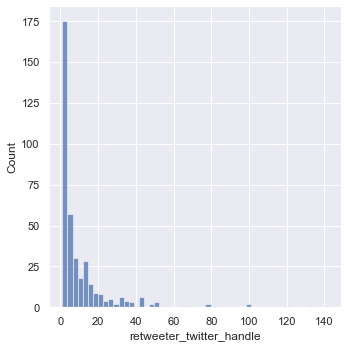

In [186]:
in_degree = sns.displot(groupby1, x="retweeter_twitter_handle")

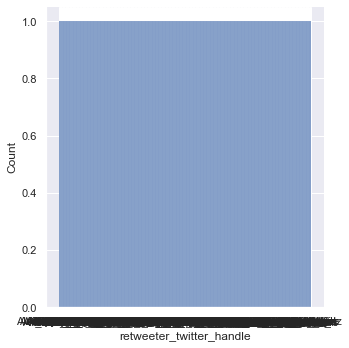

In [187]:
out_degree = sns.displot(groupby2, x="retweeter_twitter_handle")

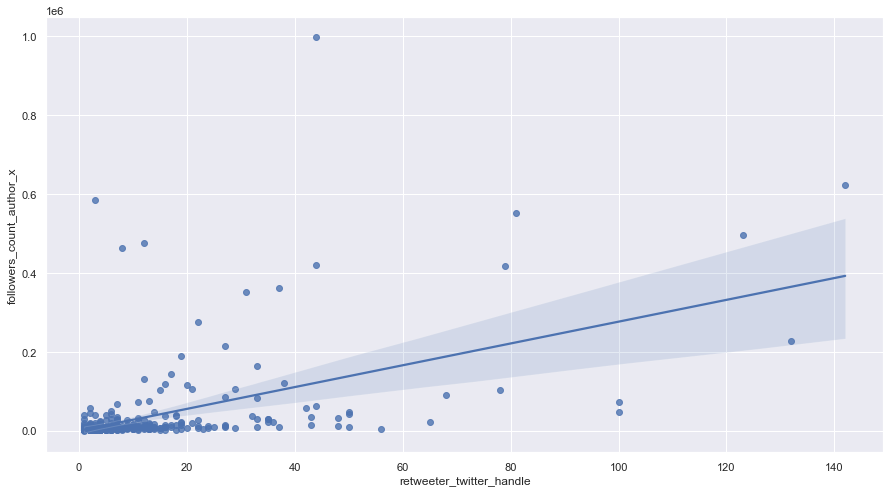

In [193]:
followers_count_reg_plot = sns.regplot(x="retweeter_twitter_handle", y="followers_count_author_x", data=in_degree_followers)

In [169]:
# check how tweets (content) differ that were only retweeted by one party/fraction